In [1]:
import gzip
import pickle
import pandas as pd
import numpy as np
import snana

LSST_FILTERS = 'ugrizY'


def read_data(filename):
    """Read data from pickled file to a pandas dataframe"""
    with gzip.open(filename, 'rb') as f:
        data = pickle.load(f)

    X = to_dataframe(data)
    y = pd.get_dummies(X.type == 0, prefix='SNIa', drop_first=True)
    X = X.drop(columns=['type'])

    return X, y


def to_dataframe(data):
    """Converts from a python dictionary to a pandas dataframe"""
    for idx in data:
        sn = data[idx]
        for filt in LSST_FILTERS:
            sn['mjd_%s' % filt] = np.array(sn[filt]['mjd'])
            sn['fluxcal_%s' % filt] = np.array(sn[filt]['fluxcal'])
            sn['fluxcalerr_%s' % filt] = np.array(sn[filt]['fluxcalerr'])
            del sn[filt]
        sn.update(sn['header'])
        del sn['header']

    return pd.DataFrame.from_dict(data, orient='index')

In [2]:
#Plot the data
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
%matplotlib inline

LSST_FILTERS = 'ugrizY'

def plot_lightcurves(idx, X):    
    
    flux = []
    for f in LSST_FILTERS:
        if len(X.iloc[idx]['fluxcal_' + f]) > 0:
            flux.append(max(X.iloc[idx]['fluxcal_' + f]))
            
    for id_f, f in enumerate(LSST_FILTERS):
        
        
        ax = axes[id_f // 3, id_f % 3]
        ax.errorbar(X.iloc[idx]['mjd_%s' % f] - X.iloc[idx]['pkmjd'], 
                    X.iloc[idx]['fluxcal_%s' % f]/max(flux), 
                    X.iloc[idx]['fluxcalerr_%s' % f]/max(flux), 
                    fmt='o', alpha=0.2)
        ax.set_xlabel('MJD')
        ax.set_ylabel('Calibrated flux')
        ax.set_title('%s-band' % f)

In [3]:
def plot_lightcurves_ideal_real(neighbors, X1, obj):  
    
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))
    fig.suptitle('%s : z=%s'%(obj.SNID, obj.z))
    
    for idx in neighbors:
        flux = []
        for f in LSST_FILTERS:
            if len(X1.iloc[idx]['fluxcal_' + f]) > 0:
                flux.append(max(X1.iloc[idx]['fluxcal_' + f]))
   
        for id_f, f in enumerate(LSST_FILTERS):
            ax = axes[id_f // 3, id_f % 3]
            ax.errorbar(X1.iloc[idx]['mjd_%s' % f] - X1.iloc[idx]['pkmjd'], 
                        X1.iloc[idx]['fluxcal_%s' % f]/max(flux), 
                        X1.iloc[idx]['fluxcalerr_%s' % f]/max(flux), 
                        fmt='o', alpha=0.5)
            ax.set_xlabel('MJD')
            ax.set_ylabel('Calibrated flux')
            ax.set_title('%s-band' % f)
    
    for id_f, f in enumerate(LSST_FILTERS):
        ax = axes[id_f // 3, id_f % 3]
        
        # if g band, look for Bessel B
        if f == 'g':
            wh_f, = np.where((obj.FLT == f) | (obj.FLT == 'B'))
        else:
            wh_f, = np.where((obj.FLT == f) | (obj.FLT == f.upper()))
            
        #uppers = [l for l in obj.FLT if l.isupper()]
        
        norm = obj.FLUXCAL/max(obj.FLUXCAL)
        norm_err = obj.FLUXCALERR/max(obj.FLUXCAL)
        ax.errorbar(obj.MJD[wh_f]-obj.PEAKMJD, norm[wh_f], yerr=norm_err[wh_f], 
                 fmt='o',
                 color='black') #, alpha=0.5)
        
        if 'CSS' in obj.SNID or '16fnl' in obj.SNID or '16ezh' in obj.SNID:
            ax.set_xlim(-150, 350)

        ax.set_xlabel('MJD')
        ax.set_ylabel('Calibrated flux')
        ax.set_title('%s-band' % f)
        
    #plt.savefig('figs/compare_TDE_%s.pdf'%obj.SNID)
    #plt.close()

# Code only works for zALL (2018-04-14)

In [6]:
X1, y1 = read_data('IDEAL_zALL_MODEL64.pkl.gz')

In [9]:
import glob
file_names = glob.glob('*lh*.snana.dat')

all_sn = []
for f in file_names:
    all_sn.append(snana.SuperNova(f))

    
redshifts = [obj.z for obj in all_sn]

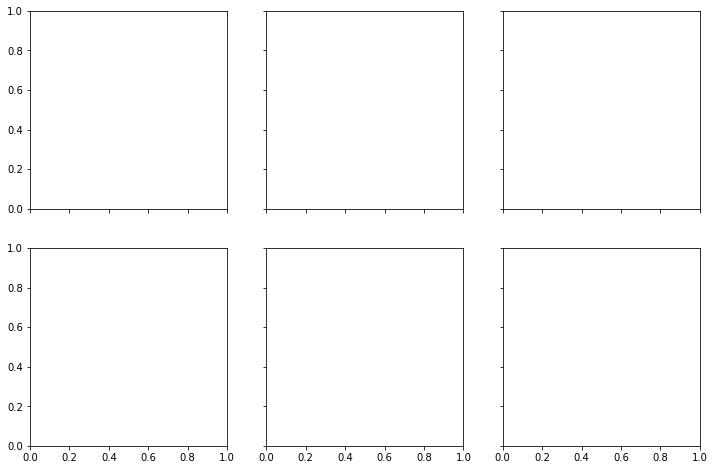

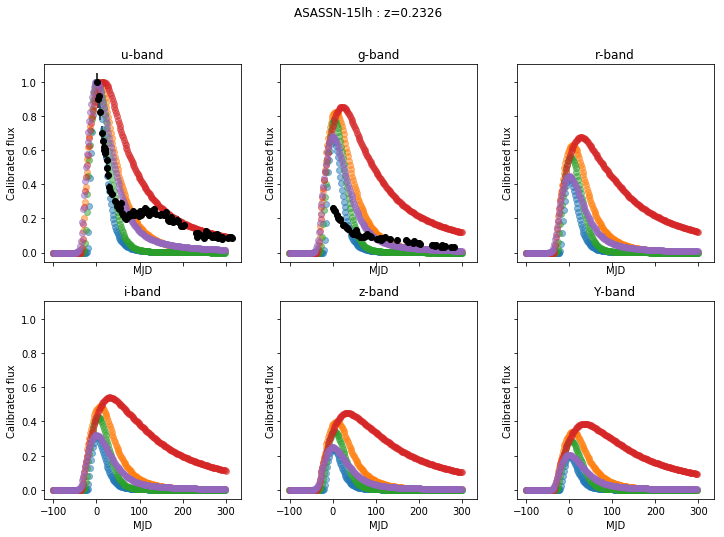

In [10]:
for z,obj in zip(redshifts, all_sn):
    if z is not None:
        neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - z) <= 0.05]
        if len(neighbors) > 12:
            neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - z) <= 0.01]
        if len(neighbors) > 12:
            neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - z) <= 0.005]
        if len(neighbors) > 12:
            neighbors = [i for i in range(y1.shape[0]) if abs(X1.z[y1.index[i]] - z) <= 0.001]
        #print(len(neighbors))
        #print(neighbors)
        fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))
        plot_lightcurves_ideal_real(neighbors, X1, obj)
    else:
        continue